### Dataset - CIFAR10

Let's first prepare the data from CIFAR10 dataset.

Source: http://www.cs.utoronto.ca/~kriz/cifar.html

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. 

(we will be using batch_1 only out of 6 batches -- so 10,000 images in total)

The classes are ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

| no. of Classes    | 10            |
|-------------------|---------------|
| Samples per class | ~1,000        |
| Samples total     | 10,000        |
| Dimensionality    | 32x32x3 = 3,072|
| Features          | int 0-255 each pixel     |


In [5]:
import pandas as pd
import numpy as np
from random import randint
from pandas import Series,DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import math
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

In [3]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

In [8]:
# source: http://www.cs.utoronto.ca/~kriz/cifar.html
# get the training data, batch 1 out of 6. do unzip the tar.gz first
from time import strftime
import os

if os.name == 'nt': # Windows
    path = 'cifar\\data_batch_1'
else:
    path = 'cifar/data_batch_1'
    
cifar = unpickle('cifar/data_batch_1')

In [9]:
def array_to_image(arr):
    im = arr.reshape((32,32,3),order='F')/255.0
    im = np.transpose(im,axes=(1,0,2))
    return im

array_size = 3072
[ 86  86  86 ..., 205 170 219]
file_name = meadow_pipit_s_001394.png


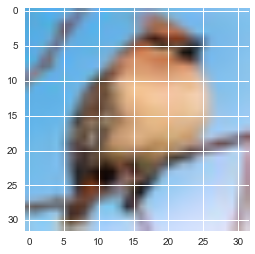

In [16]:
# image data is uint8 array format 
# 3 RGB channels and 32x32 pixels means 32x32x3 = 1024x3 = 3072 numbers in one array
# 10,000 arrays in dataset
lucky_num = randint(0,10000)
sample_arr = cifar["data"][lucky_num].copy()
print 'array_size = {}'.format(len(sample_arr))
print sample_arr
print 'file_name = {}'.format(cifar["filenames"][lucky_num])
#show image
plt.rcParams['figure.figsize'] = (4, 4)
plt.imshow(array_to_image(sample_arr))
plt.show()

# Convolutional Neural Networks (CNN)

Source1: http://cs231n.github.io/convolutional-networks/

Source2: http://lamda.nju.edu.cn/weixs/project/CNNTricks/CNNTricks.html



Note: Most of the knowledge below was gleaned from [CS231n stanford course (Source1)](http://cs231n.github.io/convolutional-networks/), its figures and explanation are excellent learning materials.

Convolutional Neural Networks (CNN) is essential normal neural nets with the "Convolution" part to transform raw input into meaningful features. Most common image, video, or other "dense" input problem.

### What is convolution anyways?

The math definition is: "the integral of 2 products after one is reversed and shifted."

$$ (f * g)(t) = \int_{-\infty}^{\infty} f(x) \cdot g(t - x) \; dx  $$

This image from wiki is much easier to understand.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/Comparison_convolution_correlation.svg/512px-Comparison_convolution_correlation.svg.png"  title="source is wiki" style="width:450px;" />

In matrix form, below is how to convolve an input matrix with another matrix (called a kernel). 

The convolution is essentially an element-wise multiplication and then sum of the result.

Here we have a 5x5 (green) input matrix and a 3x3 (orange) kernel, doing a 1-each stride (moving the kernel 1 cell a a time). 

<img src="http://i.stack.imgur.com/I7DBr.gif" title="unknown source" style="width:400px;" />


Even more useful is to look at how it was applied in real application. 

The most (visually) obvious is as a [filter in photo editor -- Edge detection, Blur, etc](http://docs.gimp.org/en/plug-in-convmatrix.html). The kernel is mostly a mask (cell value either 1 or 0) to enhance or hide away features.

<img src="http://i1.wp.com/timdettmers.com/wp-content/uploads/2015/03/convolution.png" title="source is timdettmers.com" style="width:370px;" />

So we know what convolution is now (roughly), let's move on to CNN architecture.

## CNN architecture

We're going to use the structure from [here](http://cs231n.github.io/convolutional-networks/). The source website actually contains great explanation on many concepts, so I will only do a short summary for our purpose.

Note: For the sake of easier debugging of numpy array print format, I will use this notation [Depth x Height x Width]

+ **INPUT** - [3x32x32] - will hold the raw pixel values of the image with 3 color channels.
+ **CONV** - [12x32x32] - this layer will compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. This may result in volume such as  if we decided to use 12 filters. (with each filter as [3x3x3])
+ **RELU** - [12x32x32] - layer will apply an elementwise activation function, such as the max(0,x) thresholding at zero. This leaves the size of the volume unchanged.
+ **POOL** - [12x16x16] - layer will perform a downsampling operation along the spatial dimensions (width, height).
+ **FC** - [10x1x1] - (i.e. fully-connected) layer will compute the class scores, where each of the 10 numbers correspond to a class score, such as among the 10 categories of CIFAR-10. 

Let's get into details of each layer.

### INPUT layer

Not much to be said here. we will use an image matrix of [RGB,Height,Width] = [3,32,32].

### CONV layer

First, we will use a filter (aka. kernel) matrix of RGBx3x3. 

In terms of neurons, the no. of weight (connection) for each filter is 3x3x3 + 1 bias = 28. 

Since we will have 12 filter slices (also called "depth"), we will have 28x12 = 336 connections total for **CONV** layer.

<img src="http://cs231n.github.io/assets/cnn/depthcol.jpeg" title="source from stanford course" style="width:250px;" />

The formula belows calculate the shape of the output matrix. 

For input **W**idth (or height) = 32, **F**ilter width = 3, zero-**P**adding = 1, and **S**tride = 1 :

$$ 
\begin{align}
{Output}& = \dfrac{(W + 2 \cdot P - F)}{S} + 1 \\
{Output}& = \dfrac{(32 + 2 \cdot 1 - 3)}{1} + 1 = 32
\end{align}
$$

So our output matrix from this layer is [32x32x12].

### RELU layer

we will apply a Rectified Linear Unit (ReLU) function here. The output will be the same dimension of [32x32x12].

$$ f(x) = max(0,x) $$

Or put it another way:

$$   
f(x) =
\begin{cases}
x  & \text{if } x \gt 0 \\
0 & \text{Otherwise}
\end{cases} 
$$


### POOL layer

Downsampling from [32x32x12] to [16x16x12].

We are going to use a max function of 2x2 matrix inside the 32x32 layer, therefore the output will be halved -- to [16x16x12].

<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg" title="source from stanford course" style="width:400px;" />


### FC layer

This is a normal NN output layer, connecting all [16x16x12] input to [1x1x10] predicted output.

We are going to use [Softmax function](https://en.wikipedia.org/wiki/Softmax_function) to constrain all the probability output.

$$ z_i = w_{soft} \cdot f_{POOL,i} $$

$$ \sigma_{soft}(z_i) = \cfrac{e^{z_{i}}}{ \sum_{j=0}^m e^{z_{j}} } $$

However, there is a chance that $ e^{z}$ becomes very large, which could make the computer croak by trying to divide two large numbers. 

Therefore, we can add a constant $C$ to both numerator and divisor, so the output magnitude is reasonable.

$$ \sigma_{soft}(z_i) = \cfrac{e^{z_i + C}}{ \sum_{j=0}^m e^{z_j + C} } $$

$$ C = -\max z $$

---

## Loss function

Base on [Softmax Classifier](http://cs231n.github.io/linear-classify/#softmax), the (cross-entropy) loss function is like so:

$$ L_i = - y_i \cdot \log( \; \sigma_{soft, i} \;) $$

$$ L_i = - y_i \cdot \log( \; \frac {e^{z_{i}}}{\sum e^z} \;) $$

$$ L_i = - ( \; z_{y,i} - \log \sum e^z \;) $$

$$ L = \frac{1}{N} \sum L_i $$

This roughly mean that for each instance, only use the predicted output ( $ sigma_{soft} $ ) of the correct class for that particular instance. the rest we set to zero.

For total loss over the whole dataset, we can just sum up each loss $L_i$.

## Forward Pass

This describes the flow of data.

INPUT --> CONV --> RELU --> POOL --> OUT (Softmax)

## Back Propagation

The equations and derivations are from ([this slide](http://courses.cs.tau.ac.il/Caffe_workshop/Bootcamp/pdf_lectures/Lecture%203%20CNN%20-%20backpropagation.pdf)). Backprop in [stages](http://cs231n.github.io/optimization-2/#staged) using chain rule is very useful.

For the **OUT layer**, the Softmax backprop is per below. 

$$ 
\begin{align}
\frac{\partial L}{\partial \sigma_{soft}} &= - \frac{y}{\sigma_{soft} } \\[5pt]
\frac{\partial L}{\partial z_i} &= - \frac{y_i}{\sigma_{soft,i} } \cdot \frac{\partial \sigma_{soft, i}}{\partial z_i} + \sum_{j \neq i} - \frac{y_j}{\sigma_{soft,j}} \cdot \frac{\partial \sigma_{soft, j}}{\partial f_{POOL,i}} \\[5pt]
\frac{\partial \sigma_{soft, i}}{\partial z_i} &= \sigma_{soft,i} \cdot (1 - \sigma_{soft, i}) \quad \text{,where } \sigma_{soft} \text{ is for } i \\[5pt] 
\frac{\partial \sigma_{soft, j}}{\partial z_i} &= - \sigma_{soft,j} \cdot \sigma_{soft, i} \qquad \text{,where } \sigma_{soft} \text{ is NOT for } i \\[5pt] 
\frac{\partial L}{\partial z_i} &= \sigma_{soft, i} - y_i \\[5pt]
\frac{\partial L}{\partial w_{soft}} &= (\sigma_{soft, i} - y_i) \cdot f_{POOL,i} \quad \text{, for weight update}\\[5pt]
\frac{\partial L}{\partial f_{POOL,i}} &= (\sigma_{soft, i} - y_i) \cdot w_{soft}  \qquad \text{, for pass-through to the lower layer}
\end{align}
$$
<br/>

For the **POOL layer**, we can pass the gradients directly back to the "max" input, otherwise it is zero.

$$   
\frac{\partial L}{\partial f_{RELU,i}} =
\begin{cases}
\frac{\partial L}{\partial f_{POOL,i}}  & \text{if } f_{RELU,i} \text{ is } \max \\
0 & \text{Otherwise}
\end{cases} 
$$
<br/>

For the **RELU layer**, again we can pass through the gradients directly if $ \; f_{CONV} \gt 0 $.

$$   
\frac{\partial L}{\partial f_{CONV,i}} =
\begin{cases}
\frac{\partial L}{\partial f_{RELU,i}}  & \text{if } f_{CONV,i} \gt 0 \\
0 & \text{Otherwise}
\end{cases}
$$
<br/>

For the **CONV layer**, there are a few steps. 

First, let's look a an example of convolving the [2x2] kernel $w_{r,c}$  with [3x3] input $x_{r,c}$. The result is a [2x2] $f_{r,c}$ matrix.

Note: **$r$** = row index starting at 0 and **$c$** = column index starting at 0. like so:

| $w_{0,0}$ | $w_{0,1}$ |
|-----------|-----------|
| $w_{1,0}$ | $w_{1,1}$ | 

So for forward-pass with stride = 1, we have all the $f_{r,c}$ like so :

$$
\begin{align}
f_{0,0} &= w_{0,0} \cdot x_{0,0} + w_{0,1} \cdot x_{0,1} + w_{1,0} \cdot x_{1,0} + w_{1,1} \cdot x_{1,1} + \text{bias}\\
f_{0,1} &= w_{0,0} \cdot x_{0,1} + w_{0,1} \cdot x_{0,2} + w_{1,0} \cdot x_{1,1} + w_{1,1} \cdot x_{1,2} + \text{bias}\\
f_{1,0} &= w_{0,0} \cdot x_{1,0} + w_{0,1} \cdot x_{1,1} + w_{1,0} \cdot x_{2,0} + w_{1,1} \cdot x_{2,1} + \text{bias}\\
f_{1,1} &= w_{0,0} \cdot x_{1,1} + w_{0,1} \cdot x_{1,2} + w_{1,0} \cdot x_{2,1} + w_{1,1} \cdot x_{2,2} + \text{bias}
\end{align}
$$   

Then we can calculate the gradients -- partial derivative with respect to kernel weight $w$. 

$f$ here means $f_{CONV}$, the result from CONV layer:

$$ 
\begin{align}
\frac{\partial f_{0,0}}{\partial w_{0,0}} &= x_{0,0} \\[5pt]
\frac{\partial f_{i,j}}{\partial w_{r,c}} &= x_{(i+j),(r+c)} \\[5pt]
\frac{\partial L}{\partial w_{r,c}} &= \sum_{i=0,j=0}^{n,m} \frac{\partial L}{\partial f_{i,j}} \cdot \frac{\partial f_{i,j}}{\partial w_{r,c}}  \\[5pt]
\frac{\partial L}{\partial w_{r,c}} &= \sum_{i=0,j=0}^{n,m} \frac{\partial L}{\partial f_{i,j}} \cdot x_{(i+j),(r+c)}
\end{align}
$$

For "bias", the partial derivative is 1, so we can just update it with the sum of gradients:

$$ \frac{\partial L}{\partial \text{bias}} = \sum_{i=0,j=0}^{n,m} \frac{\partial L}{\partial f_{i,j}} \cdot 1 $$

<br/>

## Optimization Method

We are going to use Stochastic gradient descent (SGD) instead of a whole training dataset. We will do a sampling of datapoints (mini-batch) and sum of the gradients.

## Computational Performance

Since this code is intended to be clear, for illustration only, not production grade, I'm trying to use "just" Numpy and build on that, only use other libraries to speed up performance as neccessary. 

---

This ends the theory part. Let's start coding!

...

..

.

## Coding Starts Here

In [597]:
# X Format is [image_index, RGB, Height, Width]
X = cifar["data"][0:10].copy()
X = X.reshape((-1,3,32,32),order='C')/255.0 - 0.5 #standardize

#set size of input, features, hidden, target
instance_size = X.shape[0]
feature_size = X.shape[1]*X.shape[2]*X.shape[3]
target_size = 10
hidden_size = 15
kernel_size = (12,3,3,3)

#make a flat 10 output with all zeros
Y = np.zeros((instance_size,10))
for j in range(0,instance_size):
    Y[j][cifar['labels'][j]] = 1

#split train and test dataset
train_split = 0.8
train_size = int(train_split*instance_size)
test_size = instance_size - train_size
index = np.random.permutation(instance_size)
train_ix, test_ix = index[:train_size], index[train_size:]
Y_train , Y_test = Y[train_ix,:], Y[test_ix,:]
X_train , X_test = X[train_ix,:,:,:], X[test_ix,:,:,:]

#Xb = np.insert(X_train,0,1,axis=1) #add bias input, always activated
#Xb_test = np.insert(X_test,0,1,axis=1) #add bias input, always activated

In [598]:
def convolve_3d_slow(data,kernel,stride,pad): 
    #73.8 ms per call --> about 10 min per 8,000 images
    tpad = ((0,0),(pad,pad),(pad,pad))
    data = np.pad(data, pad_width=tpad, mode='constant', constant_values=0)
    k_h = kernel.shape[2]
    k_w = kernel.shape[3]
    len_h = (data.shape[1] - k_h)/stride + 1
    len_w = (data.shape[2] - k_w)/stride + 1
    len_d = kernel.shape[0]
    output = np.zeros((len_d,len_h,len_w))
    for h in range(0,len_h*stride,stride):
        for w in range(0,len_w*stride,stride):      
            for d in range(0,len_d,1):
                output[d,h/stride,w/stride] = np.sum(data[:,h:(h+k_h),w:(w+k_w)]*kernel[d,:,:,:])
    return output

#import scipy.ndimage as ndi
#import scipy.signal as sig
#def convolve_3d_fast(data,kernel,stride,pad):
    #only works with stride = 1 and full padding the same size as input data though
    #output = sig.convolve(data[:,:,:],kernel[0][:,:,:],mode='valid')
    #output = sig.fftconvolve(data[:,:,:],kernel[0][:,:,:],mode='valid')
    #return output
    
def max_pool(x):
    """Return maximum in groups of 2x2 for a d,h,w image"""
    #source: http://stackoverflow.com/a/31975845
    d,h,w = x.shape
    x = x.reshape(d,h/2,2,w/2,2).swapaxes(2,3).reshape(d,h/2,w/2,4)
    return np.amax(x,axis=3)

def softmax(z):
    c = -np.max(z)
    tmp = np.exp(z + c)
    total = np.sum(tmp)
    return tmp/total

In [599]:
def backprop_f_RELU(grad_f_POOL,f_POOL_1batch,f_RELU_1batch):
    """upsample f_POOL then backprop to f_RELU """
    tmp1 = np.repeat(grad_f_POOL,2,axis=1) #expand grad down
    tmp1 = np.repeat(tmp1,2,axis=2) #expand grad right
    tmp2 = np.repeat(f_POOL_1batch,2,axis=1) #expand f_POOL down
    tmp2 = np.repeat(tmp2,2,axis=2) #expand f_POOL right
    mask = f_RELU_1batch == tmp2
    return mask*tmp1

def backprop_kernel(grad_f_CONV,x_arr):
    """ sum grad up to (12,3,3,3) per kernel dimension """
    c_img,h_img,w_img = x_arr.shape
    # (12, 32, 32) and (3,32,32) -> (12,3,32,32)
    tmp = np.einsum('ijk,ljk->iljk',grad_f_CONV,x_arr)
    grad_kernel = np.zeros(kernel_size)
    for k in range(0,kernel_size[0]): # no. of filter = 12
        for c in range(0,kernel_size[1]): # RGB = 3
            for h in range(0,kernel_size[2]): # height = 3
                for w in range(0,kernel_size[3]): # width = 3
                    #sum relevant portion (with padding = 1)
                    h_from = max(0,0-1+h)
                    h_to = min(h_img,h_img-kernel_size[2]+2+h)
                    w_from = max(0,0-1+w)
                    w_to = min(w_img,w_img-kernel_size[3]+2+w)
                    grad_kernel[k,c,h,w] = np.sum(tmp[k,c,h_from:h_to,w_from:w_to]) 
    return grad_kernel

In [600]:
import math
def loss_func(z,y):
    z = z - np.max(z)
    nom = np.sum(y*z)
    denom = math.log(np.sum(np.exp(z)))
    return -nom + denom

In [601]:
#build kernel = [Filter, RGB, Height, Width]
kernel = np.random.uniform(-0.1,0.1,size=kernel_size)
w_SOFT = np.random.uniform(-0.1,0.1,size=(10,12,16,16)) #10 sets of weight, one set of each category

loss = []

w_SOFT_learn_rate = 0.02
kernel_learn_rate = 0.02

In [680]:
#mini-batch setting, we need to cache some calculation for reuse later
mini_batch_size = 4
mini_batch = np.random.choice(train_size,size=mini_batch_size,replace=False)

#forward pass
#INPUT --> CONV --> RELU --> POOL --> OUT (Softmax)
f_CONV,f_RELU,f_POOL,f_OUT = [],[],[],[]
curr_loss = 0.0
for k in range(0,train_size):
    f_conv = convolve_3d_slow(X_train[k,:,:,:],kernel,1,1)
    f_relu = np.maximum(f_conv,0)
    f_pool = max_pool(f_relu)
    z = np.einsum('ijkl,jkl->i',w_SOFT,f_pool)
    f_CONV.append(f_conv)
    f_RELU.append(f_relu)
    f_POOL.append(f_pool)
    f_OUT.append(softmax(z))
    curr_loss += loss_func(z,Y_train[k])/train_size

loss.append(curr_loss)

#backpropagation
#kernel <-- CONV <-- RELU <-- POOL <-- OUT (Softmax)
grad_w_SOFT = np.zeros((10,12,16,16))
grad_f_POOL = np.zeros((12,16,16))
grad_f_RELU = np.zeros((12,32,32))
grad_kernel = np.zeros((12,3,3,3))
for batch in mini_batch:
    grad_w_SOFT += np.einsum('l,ijk->lijk',(f_OUT[batch] - Y_train[batch]),f_POOL[batch])
    grad_f_POOL += np.einsum('l,lijk->ijk',(f_OUT[batch] - Y_train[batch]),w_SOFT)
    grad_f_RELU += backprop_f_RELU(grad_f_POOL,f_POOL[batch],f_RELU[batch])
    grad_f_CONV = (f_CONV[batch] >0)*grad_f_RELU
    grad_kernel += backprop_kernel(grad_f_CONV,X_train[batch,:,:,:])

#update kernel and weight
w_SOFT = w_SOFT - w_SOFT_learn_rate/mini_batch_size*grad_w_SOFT
kernel = kernel - kernel_learn_rate/mini_batch_size*grad_kernel

In [681]:
np.set_printoptions(precision=4,suppress=True)
print f_OUT[0]
print f_OUT[1]
print Y_train

[ 0.0026  0.7095  0.0482  0.0044  0.0305  0.0056  0.0074  0.0267  0.0244
  0.1405]
[ 0.0037  0.2444  0.0555  0.0053  0.4554  0.0072  0.0071  0.027   0.0169
  0.1775]
[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [682]:
print ['%.3f' % val for val in loss]

['2.354', '2.311', '2.210', '2.068', '2.157', '2.081', '1.908', '1.785', '1.693', '1.662', '1.467', '1.371', '1.234', '1.129', '1.072', '1.023', '1.006', '0.845', '0.900', '0.894', '0.863', '0.825', '0.817', '0.797', '0.712']


In [657]:
print grad_kernel[0,0,:,:]

[[-0.9381 -1.1263 -1.0911]
 [-0.9913 -1.1794 -1.1472]
 [-0.9891 -1.1769 -1.1446]]


In [471]:
print f_CONV[0][1,0:6,0:6]
print '---'
print grad_f_RELU[1,0:6,0:6]
print '---'
print grad_f_CONV[1,0:6,0:6]
print f_CONV[0].shape
print grad_f_CONV.shape
#(f_CONV[batch] >0)*grad_f_RELU

[[ 0.10321725  0.14458495  0.14467959  0.14467959  0.14467959  0.14467959]
 [ 0.00876777  0.12571609  0.1241877   0.1241877   0.1241877   0.1241877 ]
 [ 0.00802462  0.12312658  0.1231739   0.1231739   0.1231739   0.1231739 ]
 [ 0.00890514  0.12483145  0.12425527  0.12425527  0.12425527  0.12425527]
 [ 0.00870507  0.1240795   0.1240795   0.1240795   0.1240795   0.1240795 ]
 [ 0.00820681  0.12405103  0.12338809  0.12391353  0.1238032   0.1240795 ]]
---
[[ 0.         -0.03173828 -0.00925955 -0.00925955  0.01361276  0.01361276]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.01568074 -0.10005253 -0.10005253 -0.05483319 -0.05483319]
 [ 0.          0.03940662  0.00407815  0.00407815 -0.01953434 -0.01953434]
 [ 0.          0.          0.          0.          0.         -0.01953434]]
---
[[ 0.         -0.03173828 -0.00925955 -0.00925955  0.01361276  0.01361276]
 [ 0.          

In [469]:
print kernel[0]

[[[ 0.09050508  0.09471033 -0.01902315]
  [ 0.03281037  0.04223372  0.07509112]
  [ 0.06852688  0.02472143 -0.0796266 ]]

 [[-0.03489337  0.07710826  0.06636818]
  [-0.01550881  0.09889109  0.05514354]
  [ 0.05085228  0.05311534 -0.01221757]]

 [[-0.04832199  0.00787875  0.09406579]
  [-0.07900967  0.031141    0.06262574]
  [-0.09653483  0.0543258  -0.00014131]]]


In [84]:
t = np.einsum('l,lijk->lijk',(f_OUT[batch] - Y[batch]),w_SOFT[:,:,:,:])
#print t[:,1,0]
m = np.sum(t,axis=0)
#print m[:,0:3,1]
#np.einsum('l,lijk->ijk',(f_OUT[batch] - Y[batch]),w_SOFT[:,:,:,:])[:,0:3,1]
print grad_f_POOL.shape
print f_RELU[0].shape
#print grad_f_POOL[1,:6,:6]
k = (f_CONV[batch] >0)*grad_f_RELU
print k[1,:6,:6]
#print t[1,:6,:6]


(12, 16, 16)
(12, 32, 32)
[[ 0.         -1.99398936 -0.4850124  -0.68734131 -1.01269432 -0.31070923]
 [-0.          0.         -0.68734131 -0.87383568 -0.21275103 -0.        ]
 [ 0.         -0.05554841  2.42473664  3.38378566  0.          0.        ]
 [-0.          0.          1.53000494  1.53000494  0.          0.        ]
 [-2.40110474 -0.          0.          1.66585929  2.7802874   2.7802874 ]
 [ 0.          0.          0.          1.91785327  2.7802874   6.03919696]]


In [971]:
a = np.array([[[ 1, 2],[ 3, 4]],
              [[5,6],[7, 8]]])

b = np.array([[-1,-2],[ 3, 1]])
c = np.array([1,2,3,4])
print b
print '---'
print c.shape
print '---'
print np.einsum('k,ij->kij',c,b)

[[-1 -2]
 [ 3  1]]
---
(4L,)
---
[[[-1 -2]
  [ 3  1]]

 [[-2 -4]
  [ 6  2]]

 [[-3 -6]
  [ 9  3]]

 [[-4 -8]
  [12  4]]]


In [955]:


a = np.reshape(np.arange(4*4*5),(4,4,5))
print a.shape
print a[0,0,:]
#b = max_pool(a)
#print b.shape
#print b

(4L, 4L, 5L)
[0 1 2 3 4]
